In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max.columns', None)

from scipy.stats import skew
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score,auc

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier



In [2]:
dataset = pd.read_csv("pd_speech_features.csv")

dataset = dataset.drop(['id'],axis=1)
dataset.shape
# dataset.head()

(756, 754)

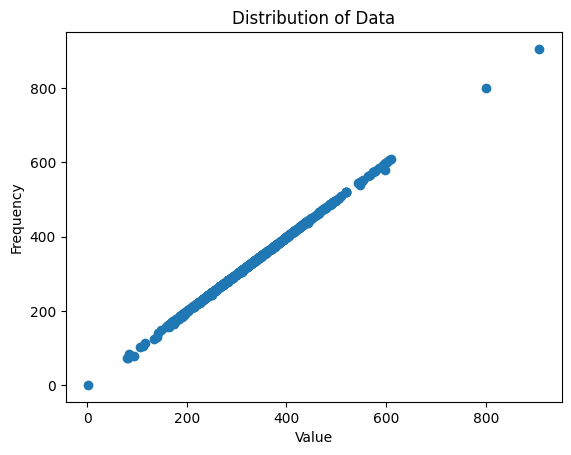

In [3]:
plt.scatter(dataset['numPulses'], dataset['numPeriodsPulses'])
plt.title('Distribution of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [4]:
column_names = list(dataset.columns)
column_names = column_names[:-1] # Removing the last attribute which is the 'CLASS'
# print(column_names)

<h1>SKEWNESS REDUCTION</h1>

In [5]:
skewedCols = []
for names in column_names:
    skewVal = dataset[names].skew()
    if(skewVal>1 or skewVal<-1):
        skewedCols.append(names)
# print(skewedCols)
print(len(skewedCols))

526


In [6]:
#   Name of the cols containing atleast one negative value
skewedCols_NegativeVals = []
for col_name in skewedCols:
    for values in dataset[col_name]:
        if(values < 0):
            skewedCols_NegativeVals.append(col_name)
            break
print(len(skewedCols_NegativeVals))

#   Name of the cols containing atleast one zero values
skewedCols_ZeroVals = []
for col_name in skewedCols:
    if col_name in skewedCols_NegativeVals:
        continue
    else:
        for values in dataset[col_name]:
            if(values == 0):
                skewedCols_ZeroVals.append(col_name)
                break
print(len(skewedCols_ZeroVals))

#   Name of the cols containing only positive values
skewedCols_PositiveVals = []
for col_name in skewedCols:
    if (col_name not in skewedCols_NegativeVals and col_name not in skewedCols_ZeroVals):
        skewedCols_PositiveVals.append(col_name)
print(len(skewedCols_PositiveVals))

147
1
378


In [7]:
#   Box-Cox Transformation
for col_name in skewedCols_PositiveVals:
    dataset[col_name] = stats.boxcox(dataset[col_name],lmbda=0)

count = 0
for col_name in skewedCols_PositiveVals:
    skewVal = dataset[col_name].skew()
    if skewVal>1 or skewVal<-1:
        count = count + 1
# print(count)
# print(dataset)

In [8]:
#   CubeRoot Transformation on skewedCols_NegativeVals & skewedCols_ZeroVals
for col_name in skewedCols_NegativeVals:
    dataset[col_name] = np.cbrt(dataset[col_name])
for col_name in skewedCols_ZeroVals:
    dataset[col_name] = np.cbrt(dataset[col_name])

count = 0
for col_name in skewedCols_NegativeVals:
    skewVal = dataset[col_name].skew()
    if skewVal>1 or skewVal<-1:
        count = count + 1
# print(count)
# print(dataset)

In [10]:
# #   Log Transformation on skewedCols_PositiveVals
# for col_name in skewedCols_PositiveVals:
#     dataset[col_name] = np.log(dataset[col_name])

# count = 0
# for col_name in skewedCols_PositiveVals:
#     skewVal = dataset[col_name].skew()
#     if skewVal>1 or skewVal<-1:
#         count = count + 1
# print(count)

<h1>Kurtosis Reduction</h1>

In [9]:
kurtosisCols = []
for names in column_names:
    kurtVal = dataset[names].kurt()
    if(kurtVal>3 or kurtVal<3):
        kurtosisCols.append(names)
# print(skewedCols)
print(len(kurtosisCols))

753


<h1>Outlier Detection</h1>

In [10]:
import statistics
for col_name in column_names:
    qi = dataset[col_name].quantile(0.25)
    qf = dataset[col_name].quantile(0.75)

    iqr = qf - qi
    c = 1.5
    upper_limit=qf+c*iqr
    lower_limit=qi-c*iqr

    col_median = statistics.mean(dataset[col_name].to_numpy())
    for val in dataset[col_name]:
        if val < lower_limit or val > upper_limit:
            dataset[col_name] = dataset[col_name].replace(val,col_median)

In [11]:
# print(dataset)

<h1>Testing the Dataset with a Model</h1>

Train Test Split.

In [154]:
print(dataset.shape)

standard = StandardScaler()

real_x = dataset.iloc[:,:-1].values
real_y = dataset.iloc[:,-1].values

real_x = standard.fit_transform(real_x)

pca=PCA(n_components=69)

pca_comp=pca.fit_transform(real_x)
# pca_comp


x_train, x_test, y_train, y_test = train_test_split(pca_comp, real_y, test_size=0.1,random_state=0)


(756, 754)


<h3><b>AUC-ROC and AUC-PR Define

In [174]:
def auc_roc(model,x_test,y_test,name):
    probas = model.predict_proba(x_test)
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_test, probas[:,0], pos_label=0)
    roc_curve = auc(fpr, tpr)

    plt.figure(dpi=100)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={roc_curve:.3f}', linestyle='--')
    plt.fill_between(fpr, tpr, color='skyblue', alpha=0.3)
    title="ROC curve for "+name

    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.legend(loc="lower right")
    plt.grid(True)

    # Add a background color
    ax = plt.gca()
    ax.set_facecolor('whitesmoke')
    plt.show()

def auc_pr(model,x_test,y_test,name):
    from sklearn.metrics import precision_recall_curve, average_precision_score,auc
    probas = model.predict_proba(x_test)
    precision,recall,thresholds=precision_recall_curve(y_test,probas[:,0],pos_label=0)
    avg_precision=average_precision_score(y_test,probas[:,1])
    pr_auc=auc(recall,precision)
    plt.figure(dpi=100)
    plt.plot(recall,precision,lw=1,color='red',label=f'AP={avg_precision:.3f};AUC={pr_auc:.3f}')
    plt.fill_between(recall,precision,-1,facecolor='y',alpha=0.5)
    title="PR curve for "+name
    plt.title(title)
    plt.xlabel('Recall(TPR)')
    plt.ylabel('Precision')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.legend()
    plt.show()

<h3><b>KNN classifiers

Best K value: 1
Best accuracy: 0.9342105263157895


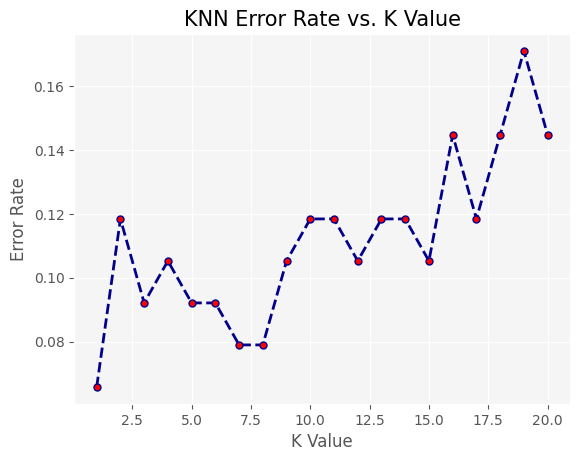

In [24]:
from sklearn.metrics import zero_one_loss
import matplotlib.pyplot as plt

error_rates = []
best_k = 1
best_accuracy = 0

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)   
    y_predict_knn = knn.predict(x_test)
    error_rate = zero_one_loss(y_test, y_predict_knn)
    error_rates.append(error_rate)

    accuracy = accuracy_score(y_test, y_predict_knn)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"Best K value: {best_k}")
print(f"Best accuracy: {best_accuracy}")

# Set plot style
plt.style.use('ggplot')

# Create a new figure
plt.figure(dpi=100)

# Plot error rates
plt.plot(range(1, 21), error_rates, color='darkblue', lw=2, linestyle='--', marker='o', markerfacecolor='red', markersize=5)

# Add title and labels
plt.title('KNN Error Rate vs. K Value', fontsize=15)
plt.xlabel('K Value', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)

# Add a grid
plt.grid(True)

# Add a background color
ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Show the plot
plt.show()

In [26]:
# Re-train the model with the best K value
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train) 
print("Accuracy : ",knn.score(x_test, y_test))
y_predict_knn = knn.predict(x_test)
cm_knn = classification_report(y_test, y_predict_knn)
print("\n")
print(cm_knn)
cm=confusion_matrix(y_test, y_predict_knn)
print(cm)

# auc_roc(knn,x_train,y_train,"KNN")
# auc_pr(knn,x_train,y_train,"KNN")


Accuracy :  0.9342105263157895


              precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1       0.97      0.95      0.96        59

    accuracy                           0.93        76
   macro avg       0.90      0.92      0.91        76
weighted avg       0.94      0.93      0.93        76

[[15  2]
 [ 3 56]]


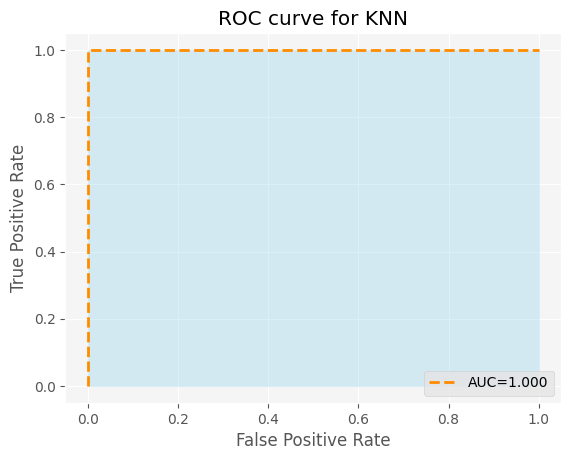

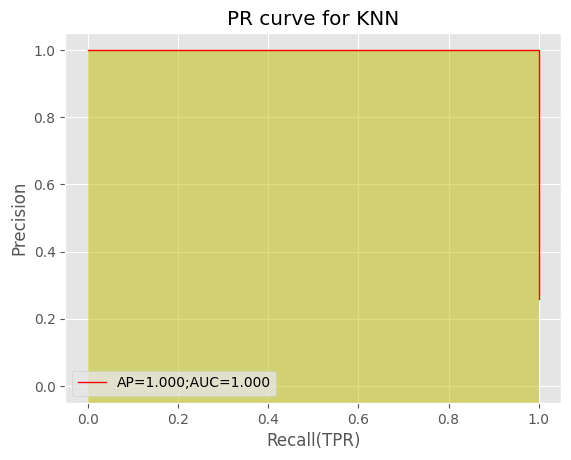

In [175]:
auc_roc(knn,x_train,y_train,"KNN")
auc_pr(knn,x_train,y_train,"KNN")

<h3><b>SVM Classifier

In [46]:
svc=SVC(probability=True).fit(x_train,y_train)
print(svc.score(x_test,y_test))
y_pred_svc=svc.predict(x_test)
cm_svc=classification_report(y_test,y_pred_svc)
print(cm_svc)
cm=confusion_matrix(y_test, y_pred_svc)
print(cm)

0.9210526315789473
              precision    recall  f1-score   support

           0       1.00      0.65      0.79        17
           1       0.91      1.00      0.95        59

    accuracy                           0.92        76
   macro avg       0.95      0.82      0.87        76
weighted avg       0.93      0.92      0.91        76

[[11  6]
 [ 0 59]]


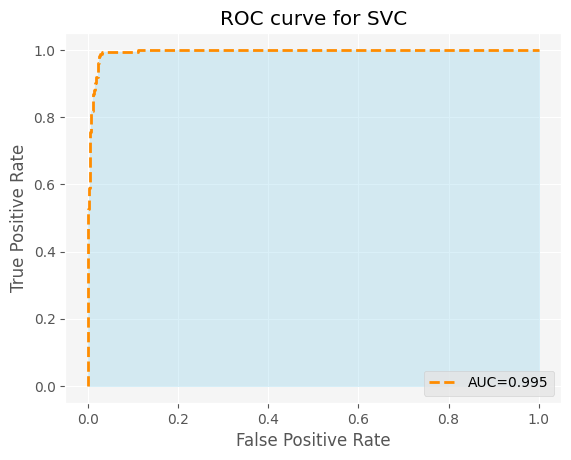

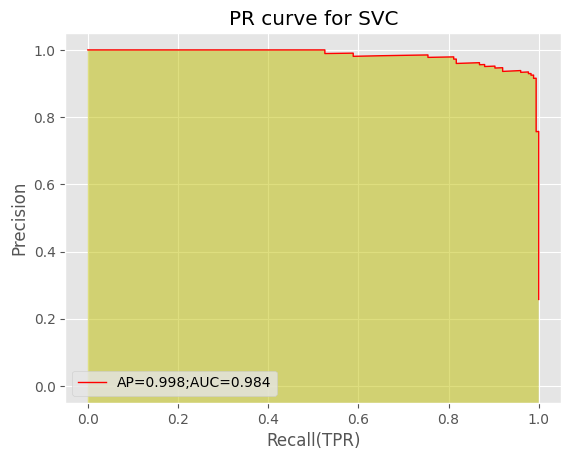

In [176]:
auc_roc(svc,x_train,y_train,"SVC")
auc_pr(svc,x_train,y_train,"SVC")

<h3><b>Decision Tree Classifier

Best depth: 27
Best accuracy: 0.868421052631579


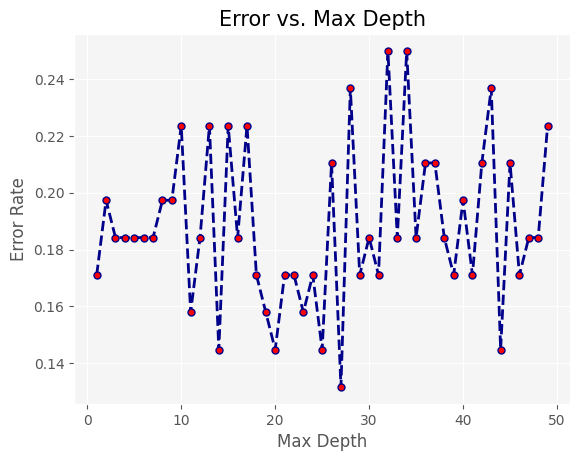

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss

# Define max_depth values to be tested
depths = range(1, 50)

# Initialize best_depth and best_accuracy
best_depth = 1
best_accuracy = 0

# Create an empty list to store error rates
error_rates = []

# Iterate through each max_depth value and calculate the error rate
for depth in depths:
    # Train the model with the current max_depth value
    dtc = DecisionTreeClassifier(max_depth=depth).fit(x_train, y_train)
    # Make predictions on the test data
    y_pred = dtc.predict(x_test)
    # Calculate the error rate and append to the error_rates list
    error_rates.append(zero_one_loss(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    # If the accuracy is higher than best_accuracy, update best_depth and best_accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth

print(f"Best depth: {best_depth}")
print(f"Best accuracy: {best_accuracy}")

# Set plot style
plt.style.use('ggplot')

# Create a new figure
plt.figure(dpi=100)

# Plot error rates
plt.plot(range(1, 50), error_rates, color='darkblue', lw=2, linestyle='--', marker='o', markerfacecolor='red', markersize=5)

# Add title and labels
plt.title('Error vs. Max Depth', fontsize=15)
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)

# Add a grid
plt.grid(True)

# Add a background color
ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Show the plot
plt.show()


In [82]:
dtc=DecisionTreeClassifier(max_depth=best_depth).fit(x_train,y_train)
print(dtc.score(x_test,y_test))
y_pred_dtc=dtc.predict(x_test)
cm_dtc=classification_report(y_test,y_pred_dtc)
print(cm_dtc)
cm=confusion_matrix(y_test, y_pred_dtc)
print(cm)


0.868421052631579
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       0.92      0.92      0.92        59

    accuracy                           0.87        76
   macro avg       0.81      0.81      0.81        76
weighted avg       0.87      0.87      0.87        76

[[12  5]
 [ 5 54]]


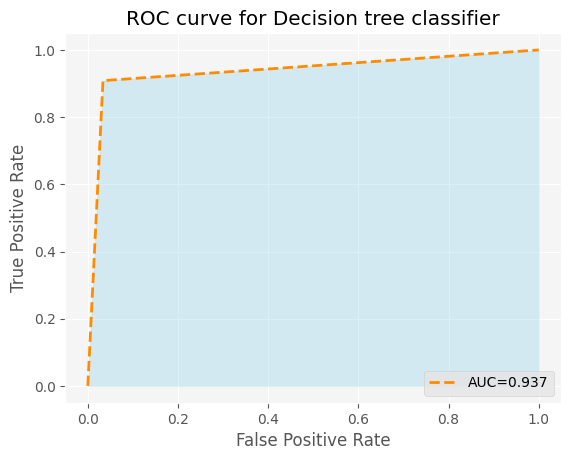

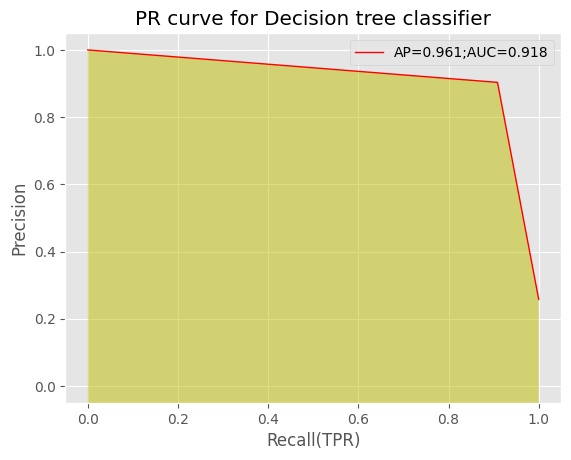

In [177]:
auc_roc(dtc,x_train,y_train,"Decision tree classifier")
auc_pr(dtc,x_train,y_train,"Decision tree classifier")

<h3><b>Random Forest Classifier

Best number of trees: 100
Best accuracy: 0.836764705882353


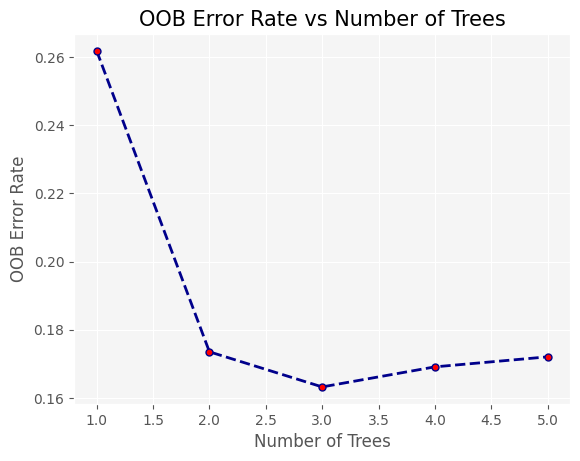

In [85]:
n_trees = [10, 50, 100, 250, 500]
oob_errors = []

# Initialize best_n and best_accuracy
best_n = 10
best_accuracy = 0

for n in n_trees:
    rfc = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42)
    rfc.fit(x_train, y_train)
    oob_errors.append(1 - rfc.oob_score_)

    # Calculate the accuracy
    accuracy = rfc.oob_score_
    # If the accuracy is higher than best_accuracy, update best_n and best_accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n = n

print(f"Best number of trees: {best_n}")
print(f"Best accuracy: {best_accuracy}")

# Set plot style
plt.style.use('ggplot')

# Create a new figure
plt.figure(dpi=100)

# Plot error rates
plt.plot(range(1, 6), oob_errors, color='darkblue', lw=2, linestyle='--', marker='o', markerfacecolor='red', markersize=5)

# Add title and labels
plt.title('OOB Error Rate vs Number of Trees', fontsize=15)
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('OOB Error Rate', fontsize=12)

# Add a grid
plt.grid(True)

# Add a background color
ax = plt.gca()
ax.set_facecolor('whitesmoke')

# Show the plot
plt.show()

In [87]:
rfc = RandomForestClassifier(n_estimators=best_n, oob_score=True, random_state=42).fit(x_train,y_train)
print(rfc.score(x_test,y_test))
y_pred_rfc=rfc.predict(x_test)
cm_rfc=classification_report(y_test,y_pred_rfc)
print(cm_rfc)
cm=confusion_matrix(y_test, y_pred_rfc)
print(cm)


0.881578947368421
              precision    recall  f1-score   support

           0       1.00      0.47      0.64        17
           1       0.87      1.00      0.93        59

    accuracy                           0.88        76
   macro avg       0.93      0.74      0.78        76
weighted avg       0.90      0.88      0.86        76

[[ 8  9]
 [ 0 59]]


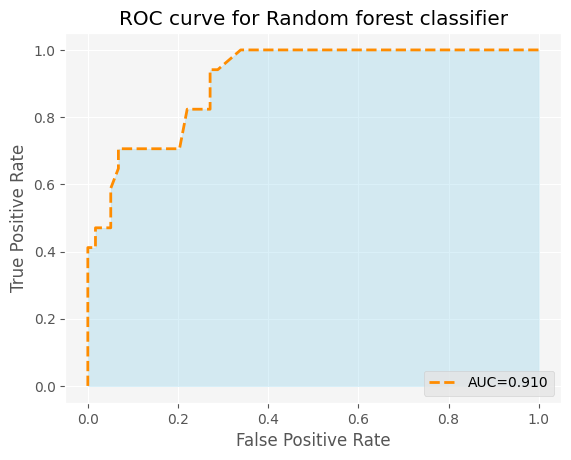

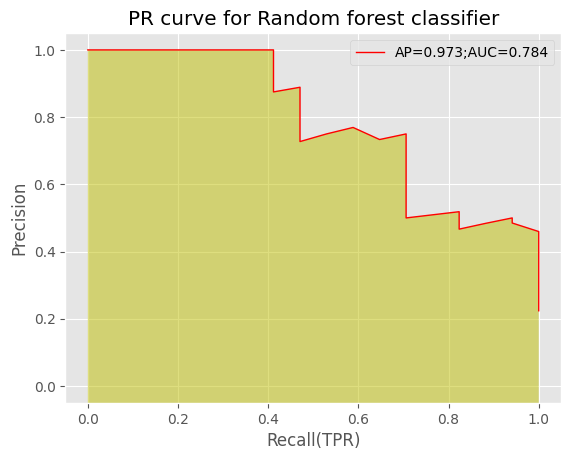

In [178]:
auc_roc(rfc,x_test,y_test,"Random forest classifier")
auc_pr(rfc,x_test,y_test,"Random forest classifier")

<h3><b>Naive bayes classifier.

In [105]:
nbc=GaussianNB().fit(x_train,y_train)
print(nbc.score(x_test,y_test))
y_pred_nbc=nbc.predict(x_test)
cm_nbc=classification_report(y_test,y_pred_nbc)
print(cm_nbc)
cm=confusion_matrix(y_test, y_pred_nbc)
print(cm)


0.868421052631579
              precision    recall  f1-score   support

           0       0.73      0.65      0.69        17
           1       0.90      0.93      0.92        59

    accuracy                           0.87        76
   macro avg       0.82      0.79      0.80        76
weighted avg       0.86      0.87      0.87        76

[[11  6]
 [ 4 55]]


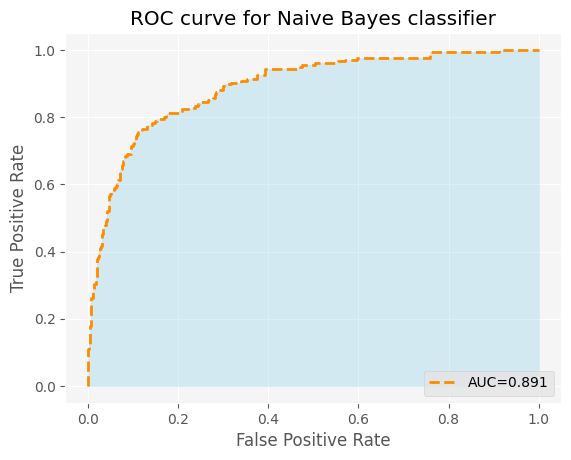

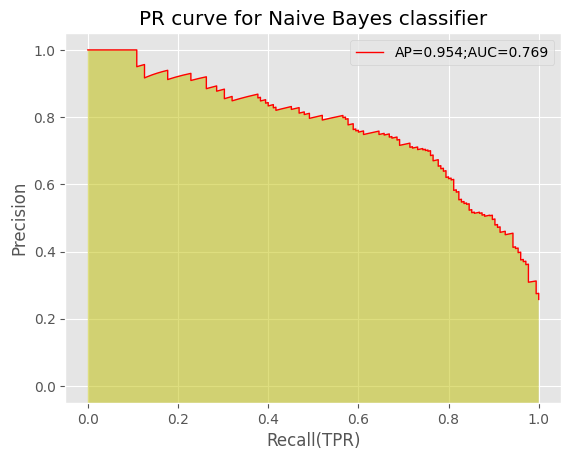

In [179]:
auc_roc(nbc,x_train,y_train,"Naive Bayes classifier")
auc_pr(nbc,x_train,y_train,"Naive Bayes classifier")

<h3><b>Logistic regression

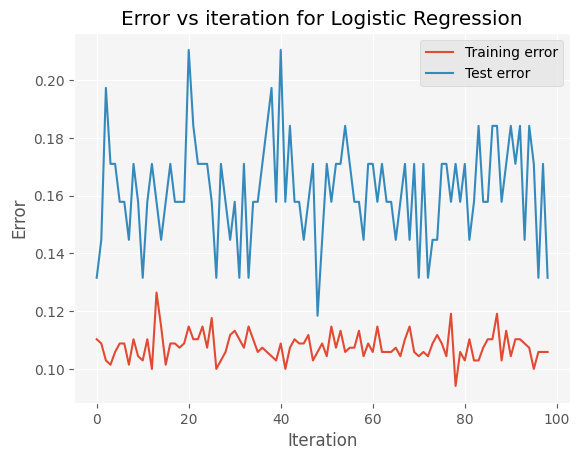

In [138]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Create and fit the model with warm_start=True
def tts(dataset):
    # print(dataset.shape)

    standard = StandardScaler()

    real_x = dataset.iloc[:,:-1].values
    real_y = dataset.iloc[:,-1].values

    real_x = standard.fit_transform(real_x)

    pca=PCA(n_components=69)

    pca_comp=pca.fit_transform(real_x)
    # pca_comp


    x_train, x_test, y_train, y_test = train_test_split(pca_comp, real_y, test_size=0.1,random_state=0)
    return x_train, x_test, y_train, y_test


train_errors = []
test_errors = []

for i in range(1, 100):
    x_train, x_test, y_train, y_test=tts(dataset)

    lgr = LogisticRegression(warm_start=True)
    lgr.fit(x_train, y_train)
    train_errors.append(1 - lgr.score(x_train, y_train))
    test_errors.append(1 - lgr.score(x_test, y_test))

# Plot the error graph
plt.plot(train_errors, label='Training error')
plt.plot(test_errors, label='Test error')
plt.legend()
plt.title('Error vs iteration for Logistic Regression')
plt.xlabel('Iteration')
plt.ylabel('Error')

# Add a grid
plt.grid(True)

# Add a background color
ax = plt.gca()
ax.set_facecolor('whitesmoke')

plt.show()



In [139]:
lgr=LogisticRegression().fit(x_train,y_train)
print(lgr.score(x_test,y_test))
y_pred_lgr=lgr.predict(x_test)
cm_lgr=classification_report(y_test,y_pred_lgr)
print(cm_lgr)
cm=confusion_matrix(y_test, y_pred_lgr)
print(cm)
# auc_roc(lgr,x_train,y_train,"Logistic Regression")
# auc_pr(rfc,x_test,y_test,"Logistic regression")

0.868421052631579
              precision    recall  f1-score   support

           0       0.71      0.71      0.71        17
           1       0.92      0.92      0.92        59

    accuracy                           0.87        76
   macro avg       0.81      0.81      0.81        76
weighted avg       0.87      0.87      0.87        76

[[12  5]
 [ 5 54]]


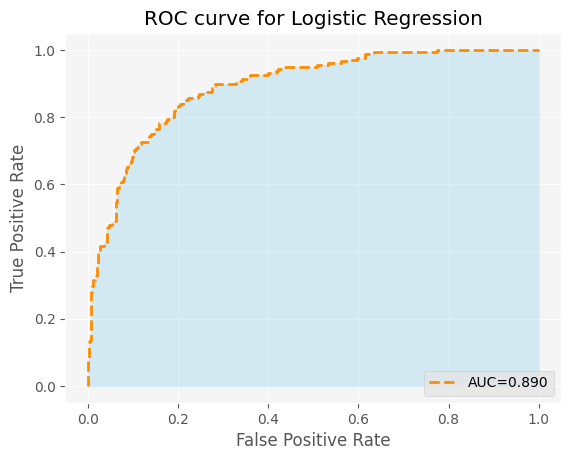

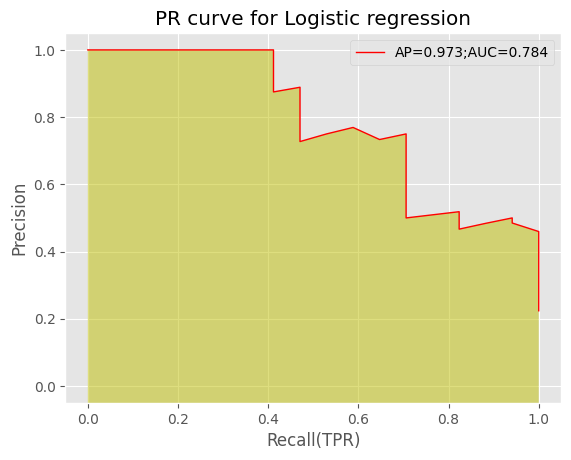

In [180]:
auc_roc(lgr,x_train,y_train,"Logistic Regression")
auc_pr(rfc,x_test,y_test,"Logistic regression")

<h3><b>XGBoost Classifiers

[0]	validation_0-error:0.08625	validation_1-error:0.07500
[1]	validation_0-error:0.05625	validation_1-error:0.07500
[2]	validation_0-error:0.05125	validation_1-error:0.07000
[3]	validation_0-error:0.03750	validation_1-error:0.07500
[4]	validation_0-error:0.03750	validation_1-error:0.07000
[5]	validation_0-error:0.03750	validation_1-error:0.06500
[6]	validation_0-error:0.03750	validation_1-error:0.06000
[7]	validation_0-error:0.03250	validation_1-error:0.06500
[8]	validation_0-error:0.03625	validation_1-error:0.06500
[9]	validation_0-error:0.03375	validation_1-error:0.06000
[10]	validation_0-error:0.03000	validation_1-error:0.06000
[11]	validation_0-error:0.02875	validation_1-error:0.06500
[12]	validation_0-error:0.02750	validation_1-error:0.06500
[13]	validation_0-error:0.02750	validation_1-error:0.06500
[14]	validation_0-error:0.02625	validation_1-error:0.06500
[15]	validation_0-error:0.02500	validation_1-error:0.07000
[16]	validation_0-error:0.02625	validation_1-error:0.06500
[17]	va

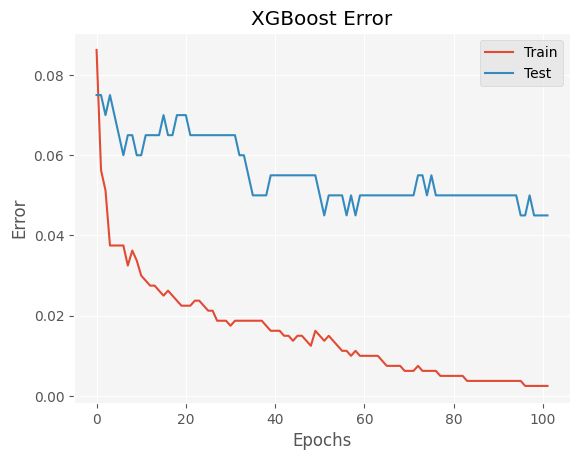

In [152]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate a random dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, random_state=42)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBClassifier with eval_set
xgbc = XGBClassifier(n_estimators=1000, learning_rate=0.05)
eval_set = [(X_train, y_train), (X_test, y_test)]
xgbc.fit(X_train, y_train, eval_set=eval_set, eval_metric='error', early_stopping_rounds=50)

# Plot the error graph
results = xgbc.evals_result()
train_error = results['validation_0']['error']
test_error = results['validation_1']['error']
epochs = len(train_error)
x_axis = range(0, epochs)

plt.plot(x_axis, train_error, label='Train')
plt.plot(x_axis, test_error, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.legend()

# Add a grid
plt.grid(True)

# Add a background color
ax = plt.gca()
ax.set_facecolor('whitesmoke')

plt.show()

In [161]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define and fit the model
xgbc = XGBClassifier().fit(x_train, y_train)

# Predict the labels for the test data
y_pred_xgbc = xgbc.predict(x_test)

# Calculate the accuracy
acc = accuracy_score(y_test, y_pred_xgbc)
print(acc)

# Print the classification report
cm_xgb = classification_report(y_test, y_pred_xgbc)
print(cm_xgb)

0.8947368421052632
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        17
           1       0.95      0.92      0.93        59

    accuracy                           0.89        76
   macro avg       0.84      0.87      0.85        76
weighted avg       0.90      0.89      0.90        76



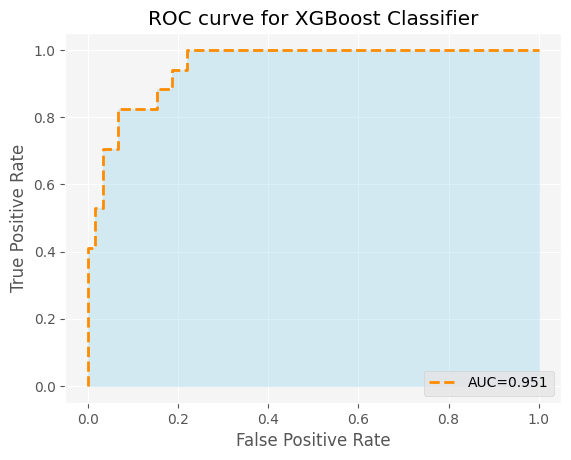

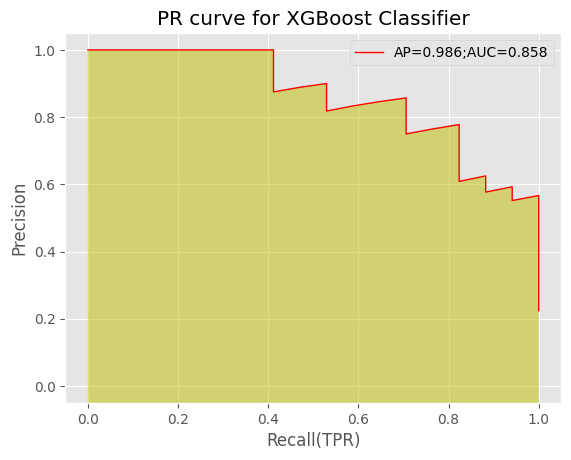

In [181]:
auc_roc(xgbc,x_test,y_test,"XGBoost Classifier")
auc_pr(xgbc,x_test,y_test,"XGBoost Classifier")

<h3><b>Gradient Boosting Classifier

0.8421052631578947
              precision    recall  f1-score   support

           0       0.65      0.65      0.65        17
           1       0.90      0.90      0.90        59

    accuracy                           0.84        76
   macro avg       0.77      0.77      0.77        76
weighted avg       0.84      0.84      0.84        76



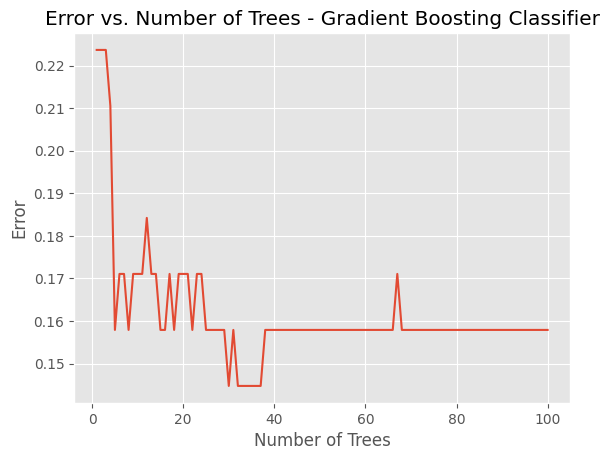

In [162]:
from sklearn.metrics import zero_one_loss

gbc=GradientBoostingClassifier().fit(x_train,y_train)
print(gbc.score(x_test,y_test))
y_pred_gbc=gbc.predict(x_test)
cm_gbc=classification_report(y_test,y_pred_gbc)
print(cm_gbc)

errors = []
for y_pred in gbc.staged_predict(x_test):
    errors.append(zero_one_loss(y_pred, y_test))

n_trees = len(gbc)
plt.plot(range(1, n_trees + 1), errors)
plt.xlabel('Number of Trees')
plt.ylabel('Error')
plt.title('Error vs. Number of Trees - Gradient Boosting Classifier')
plt.show()




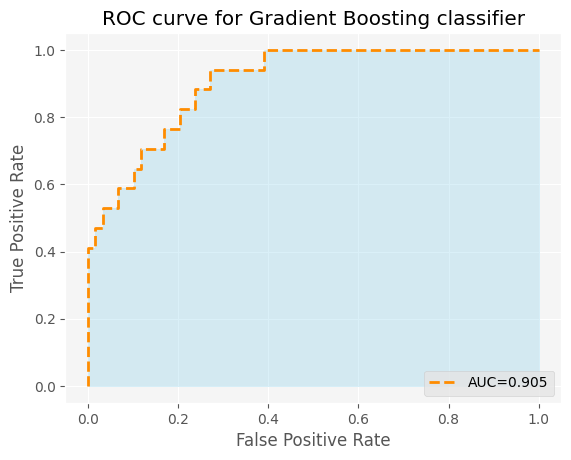

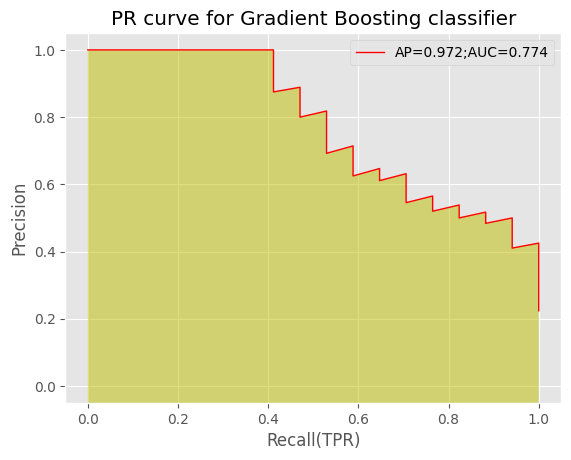

In [182]:
auc_roc(gbc,x_test,y_test,"Gradient Boosting classifier")
auc_pr(gbc,x_test,y_test,"Gradient Boosting classifier")

Standard scaling.

In [36]:
from sklearn.preprocessing import StandardScaler
# get the features and label from the original dataframe
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]
# performing standardization
sc = StandardScaler()
X_scaled = sc.fit_transform(X)


In [37]:
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset

df = dataset
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[['class']])
output=transformed.toarray()

# print(transformed.toarray())

In [38]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
shape = list(dataset.shape)
# for i in range(11,55):
components = 17
_sc = StandardScaler()
_pca = PCA(n_components = components)

_model = MLPClassifier(hidden_layer_sizes=(shape[0]//2,shape[1]//2))
pipeline_model = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca),
    ('classifier', _model)
])
# perform a split
X_train, X_test, y_train, y_test =train_test_split(X, output, test_size=0.1, random_state=0)
# train the model using the PCA components
pipeline_model.fit(X_train,y_train)

print(pipeline_model.score(X_test,y_test))

0.9210526315789473


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras import backend as K
import tensorflow as tf

In [35]:
data_val=dataset.values

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [40]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [41]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)      

In [49]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(x_train, epochs=20, validation_data=x_test, callbacks=[tensorboard_callback])

ValueError: Failed to find data adapter that can handle input: <class 'numpy.bool_'>, <class 'NoneType'>

In [44]:
model.fit(x_train, y_train,
          epochs=20,
          batch_size= 160)
score = model.evaluate(X_test, y_test, batch_size=128)

Epoch 1/20


ValueError: in user code:

    File "d:\CODING\anaconda\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "d:\CODING\anaconda\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\CODING\anaconda\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "d:\CODING\anaconda\lib\site-packages\keras\engine\training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "d:\CODING\anaconda\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\CODING\anaconda\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 17)


In [ ]:
model.summary()